# Mounting google drive and loading the dataset

- TrainA and TestA contain normal photographs
- TrainB and TestB contain oil paintings

In [1]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/archive.zip -d Images

In [ ]:
# Installing required packages

!pip install tensorflow-addons
!pip install tensorflow

In [4]:
import tensorflow as tf
import os
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback
import random

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# Loading jpg images and resizing them to to 256, 256 in order for easy training, lim is the max limit on images we want to load(set due to memory issues)
def load_images_from_directory(directory, size=(256, 256), lim=1000):
    images = []
    for filename in random.choices(os.listdir(directory), k=lim):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(size)
                img_array = np.array(img)
                images.append(img_array)
    return np.array(images)

def preprocess_images(images):
    # Normalize images to range [-1, 1]
    images = (images / 127.5) - 1
    return images

def create_dataset(images, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(len(images)).batch(batch_size)
    return dataset

In [26]:
style_images = create_dataset(preprocess_images(load_images_from_directory('Images/oil_painting/trainB')), 1)
photo_images = create_dataset(preprocess_images(load_images_from_directory('Images/oil_painting/trainA')), 1)

In [7]:
def visualize_images(ds, title, samples=5):
    num_cols = min(samples, 5)
    num_rows = (samples + num_cols - 1) // num_cols
    plt.figure(figsize=(4*num_cols, 4*num_rows))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

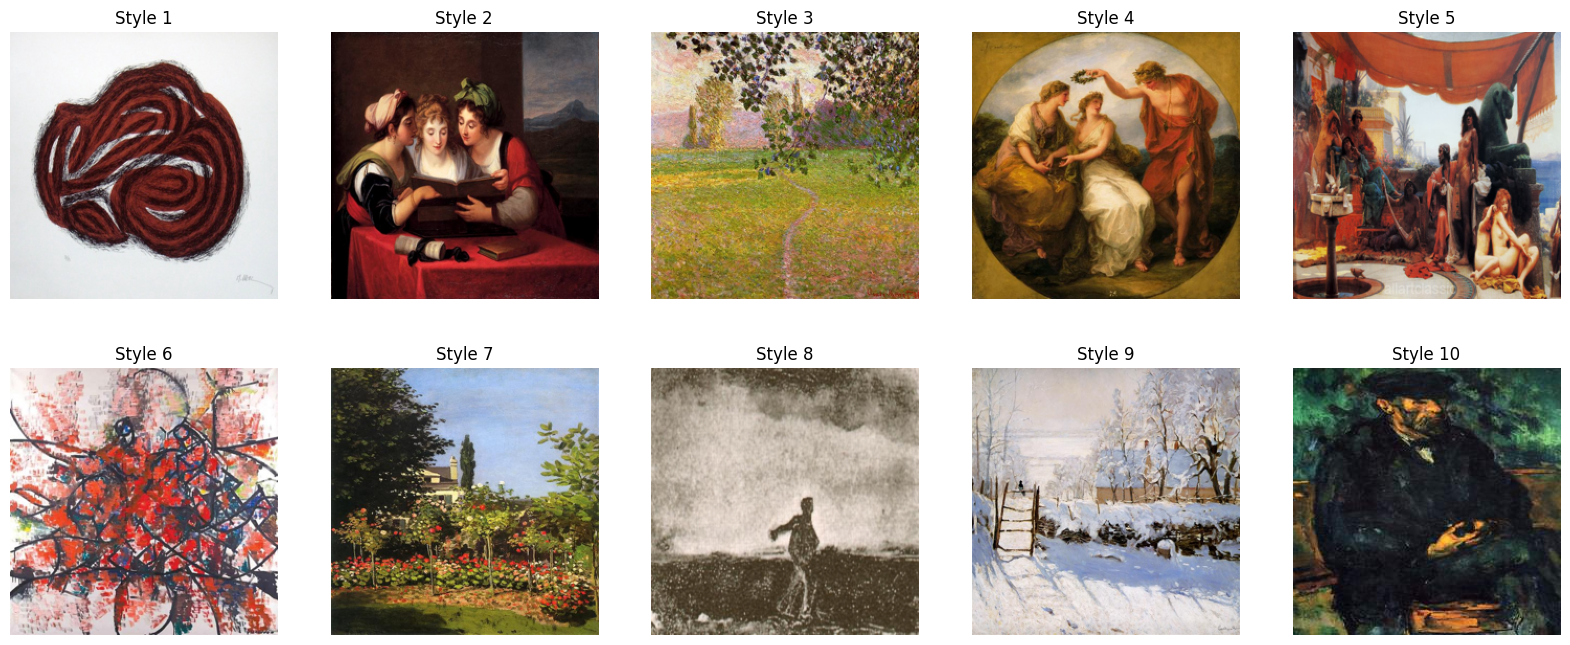

In [8]:
visualize_images(style_images,'Style',10)

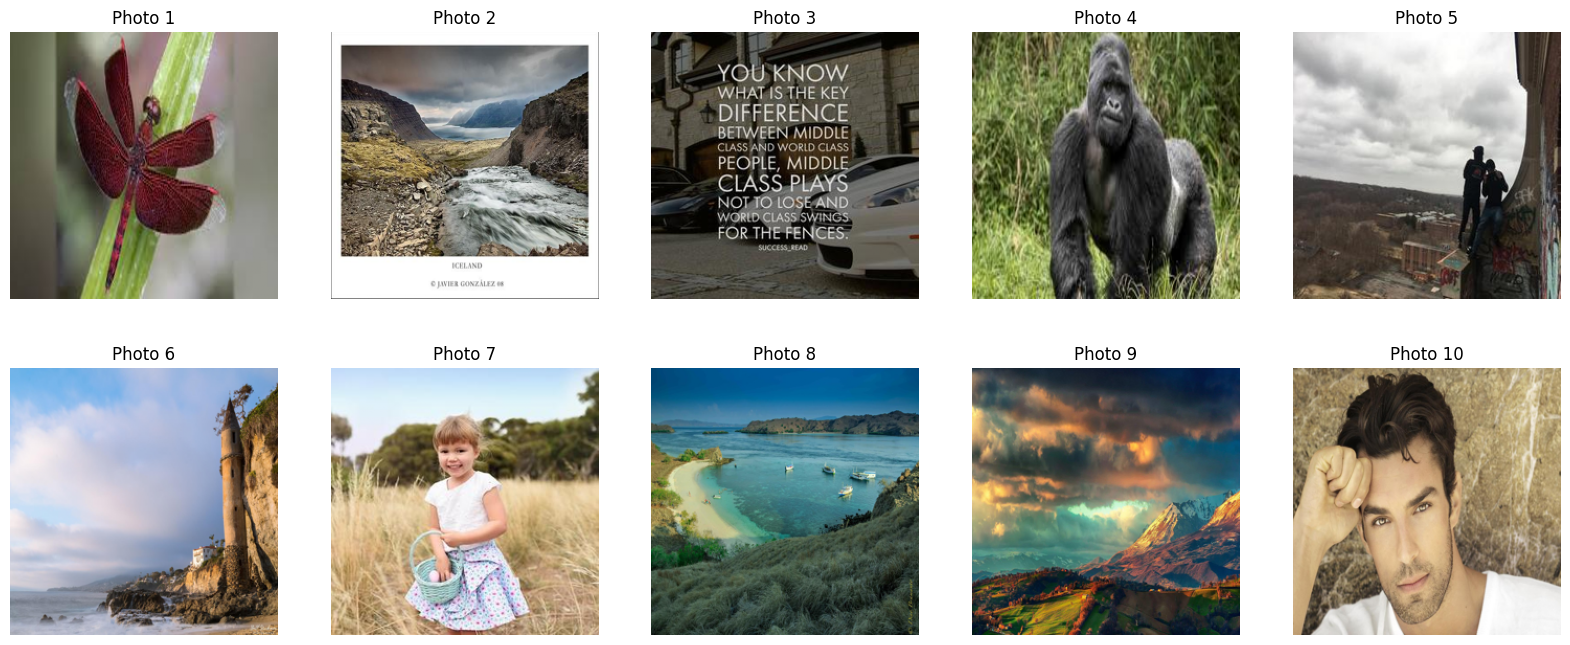

In [9]:
visualize_images(photo_images, 'Photo', 10)

**CycleGAN Model generator and discriminators**

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
# Discriminator loss function

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5



In [15]:
# Generator loss function

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [16]:
# Cycle loss

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    real_image = tf.cast(real_image, tf.float32)
    cycled_image = tf.cast(cycled_image, tf.float32)
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [17]:
# Identity loss

def identity_loss(real_image, same_image, LAMBDA):
    real_image = tf.cast(real_image, tf.float32)
    same_image = tf.cast(same_image, tf.float32)
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [18]:
style_generator = Generator() # transforms photos to style
photo_generator = Generator() # transforms style to be more like photos

style_discriminator = Discriminator() # differentiates real style and generated style
photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,style_generator,photo_generator,style_discriminator,photo_discriminator,lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.s_gen = style_generator
        self.p_gen = photo_generator
        self.s_disc = style_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self,s_gen_optimizer,p_gen_optimizer,s_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn, identity_loss_fn,run_eagerly=False):
        super(CycleGan, self).compile()
        self.s_gen_optimizer = s_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.s_disc_optimizer = s_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.run_eagerly = run_eagerly

    def train_step(self, batch_data):
        real_style, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to style back to photo
            fake_style = self.s_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_style, training=True)

            # style to photo back to style
            fake_photo = self.p_gen(real_style, training=True)
            cycled_style = self.s_gen(fake_photo, training=True)

            # generating itself
            same_style = self.s_gen(real_style, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_style = self.s_disc(real_style, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_style = self.s_disc(fake_style, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            style_gen_loss = self.gen_loss_fn(disc_fake_style)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_style, cycled_style, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_style_gen_loss = style_gen_loss + total_cycle_loss + self.identity_loss_fn(real_style, same_style, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            style_disc_loss = self.disc_loss_fn(disc_real_style, disc_fake_style)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        style_generator_gradients = tape.gradient(total_style_gen_loss,self.s_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        style_discriminator_gradients = tape.gradient(style_disc_loss, self.s_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.s_gen_optimizer.apply_gradients(zip(style_generator_gradients, self.s_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))

        self.s_disc_optimizer.apply_gradients(zip(style_discriminator_gradients,self.s_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))

        return {
            "style_gen_loss": total_style_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "style_disc_loss": style_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [20]:
# learning rate and beta are hyperparameters

style_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

style_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
cycle_gan_model = CycleGan(style_generator, photo_generator, style_discriminator, photo_discriminator)

cycle_gan_model.compile(
        s_gen_optimizer = style_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        s_disc_optimizer = style_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss,
        run_eagerly=False
)



In [22]:
# Training the model

hist=cycle_gan_model.fit(
    tf.data.Dataset.zip((style_images, photo_images)),
    epochs=30
)

Epoch 1/30
999/999 [==============================] - 264s 186ms/step - style_gen_loss: 4.1777 - photo_gen_loss: 4.1754 - style_disc_loss: 0.6664 - photo_disc_loss: 0.6562
Epoch 2/30
999/999 [==============================] - 186s 186ms/step - style_gen_loss: 2.9971 - photo_gen_loss: 3.0334 - style_disc_loss: 0.6791 - photo_disc_loss: 0.6558
Epoch 3/30
999/999 [==============================] - 187s 187ms/step - style_gen_loss: 2.7971 - photo_gen_loss: 2.7781 - style_disc_loss: 0.6602 - photo_disc_loss: 0.6622
Epoch 4/30
999/999 [==============================] - 186s 187ms/step - style_gen_loss: 2.7236 - photo_gen_loss: 2.6493 - style_disc_loss: 0.6478 - photo_disc_loss: 0.6659
Epoch 5/30
999/999 [==============================] - 187s 187ms/step - style_gen_loss: 2.6435 - photo_gen_loss: 2.5641 - style_disc_loss: 0.6445 - photo_disc_loss: 0.6628
Epoch 6/30
999/999 [==============================] - 185s 185ms/step - style_gen_loss: 2.5708 - photo_gen_loss: 2.4885 - style_disc_loss: 0

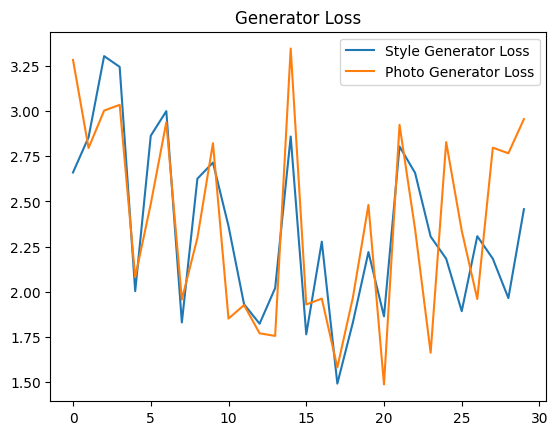

In [23]:
style_gen_loss_values = np.mean(hist.history['style_gen_loss'], axis=(1, 2, 3))
photo_gen_loss_values = np.mean(hist.history['photo_gen_loss'], axis=(1, 2, 3))

plt.plot(style_gen_loss_values)
plt.plot(photo_gen_loss_values)

plt.legend(["Style Generator Loss","Photo Generator Loss"])

plt.title("Generator Loss")
plt.show()



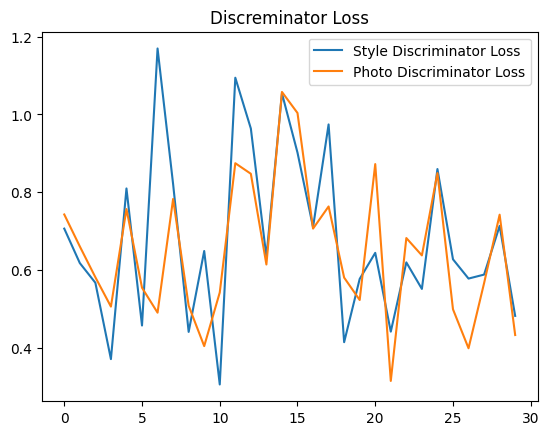

In [24]:
style_disc_loss_values = np.mean(hist.history['style_disc_loss'], axis=(1, 2, 3))
photo_disc_loss_values = np.mean(hist.history['photo_disc_loss'], axis=(1, 2, 3))
plt.plot(style_disc_loss_values)
plt.plot(photo_disc_loss_values)
plt.title("Discreminator Loss")
plt.legend(["Style Discriminator Loss","Photo Discriminator Loss"])
plt.show()

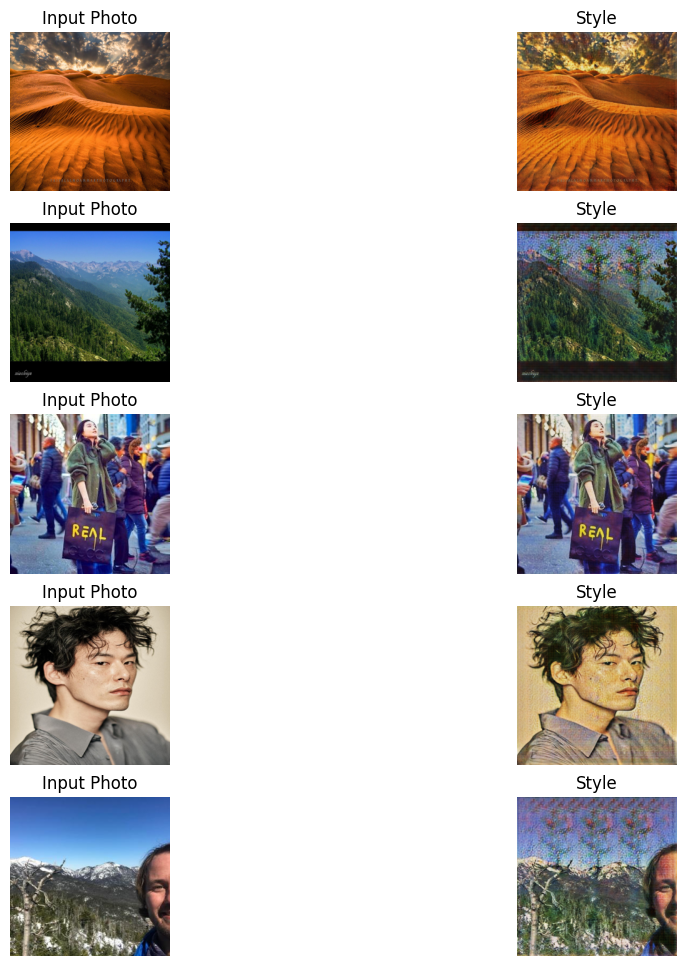

In [25]:
# Testing on test dataset

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_images.take(5)):
    prediction = style_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [28]:
photo_images_test = create_dataset(preprocess_images(load_images_from_directory('Images/oil_painting/testA', lim=50)), 1)

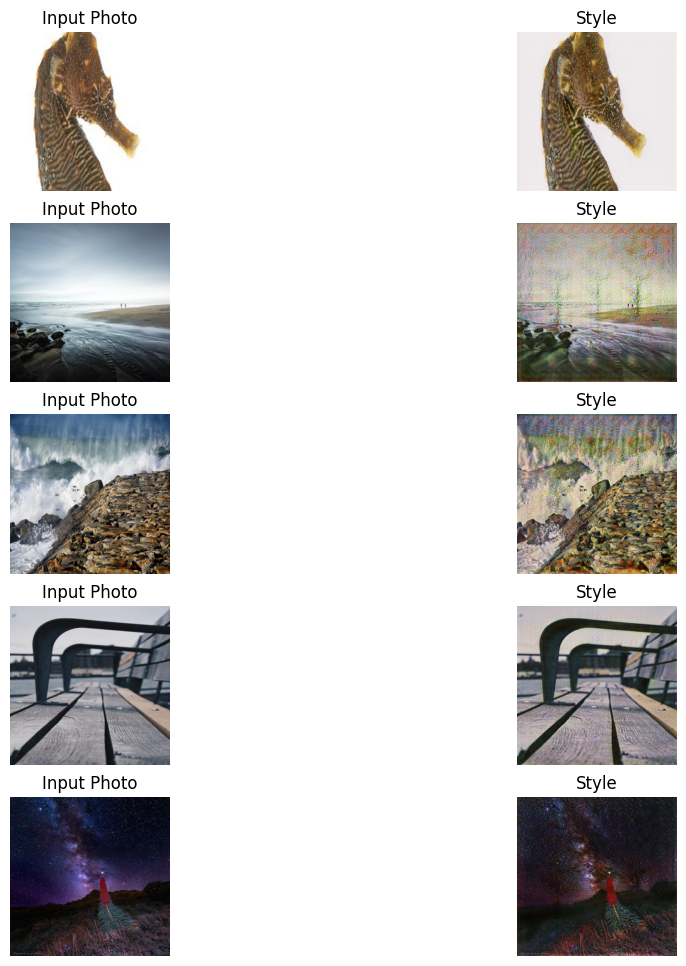

In [30]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_images_test.take(5)):
    prediction = style_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()